# Inference

This is the final step in a series, part of the code and idea form:  
  * [Create COCO annotations for Sartorius dataset](https://www.kaggle.com/mistag/sartorius-create-coco-annotations)
  * [Cell shape analysis](https://www.kaggle.com/mistag/sartorius-cell-shape-analysis)
  * [Offline Detectron2 files](https://www.kaggle.com/mistag/detectron2-download-code-for-offline-install-ii)
  * [Train CenterMask2 model](https://www.kaggle.com/mistag/train-sartorius-detectron2-centermask2)
  * [Sartorius: TTA with Weighted Segments Fusion](https://www.kaggle.com/mistag/sartorius-tta-with-weighted-segments-fusion)
 
Start by installing Dectectron2:

In [1]:
!pip install --no-index \
../input/detectron2-download-code-for-offline-install-ii/detectron2/detectron2-0.6-cp37-cp37m-linux_x86_64.whl \
--find-links=../input/detectron2-download-code-for-offline-install-ii/detectron2

Looking in links: ../input/detectron2-download-code-for-offline-install-ii/detectron2
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/detectron2-0.6-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/omegaconf-2.1.1-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/fvcore-0.1.5.post20211023-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/hydra_core-1.1.1-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/iopath-0.1.9-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/black-21.4b2-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-insta

Then install Weighted Segments Boxes for Segments Fusion:

In [2]:
!cp /kaggle/input/tta-with-weighted-segments-fusion/wbf_tracking.py

cp: missing destination file operand after '/kaggle/input/tta-with-weighted-segments-fusion/wbf_tracking.py'
Try 'cp --help' for more information.


Copy CenterMask2 from [training notebook](https://www.kaggle.com/jieqingyang/centermask-lite-v-39-ese-fpn-ms-4x-offline):

In [3]:
%cd /kaggle/working
!cp -R ../input/centermask2litev19slim13000 centermask2

/kaggle/working


Install a few libraries:

In [4]:
import numpy as np
import pandas as pd
import os, json, cv2, random
import matplotlib.pyplot as plt
import glob, gc
from skimage import measure
import albumentations as A
from skimage import measure
import os
import sys
module_path = os.path.abspath(os.path.join('/kaggle/input/tta-with-weighted-segments-fusion/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from wbf_tracking import weighted_boxes_fusion_tracking
from scipy import stats
import torch
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Configure model for inference:

In [5]:
%cd /kaggle/working/centermask2

from centermask.config import get_cfg # important! Use get_cfg from the centermask repo and not Detectron2

cfg = get_cfg()
cfg.merge_from_file("/kaggle/input/litev39/test.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = '/kaggle/input/litev39/output/model_final.pth'
cfg.MODEL.FCOS.POST_NMS_TOPK_TEST = 800 # Max number of detections per image
predictor = DefaultPredictor(cfg)

/kaggle/working/centermask2


# Sanity check on the three public test images
The number of detections per image is set high, so the unfiltered predictions below will look cluttered...

In [6]:
test_files = glob.glob('/kaggle/input/sartorius-cell-instance-segmentation/test/*')

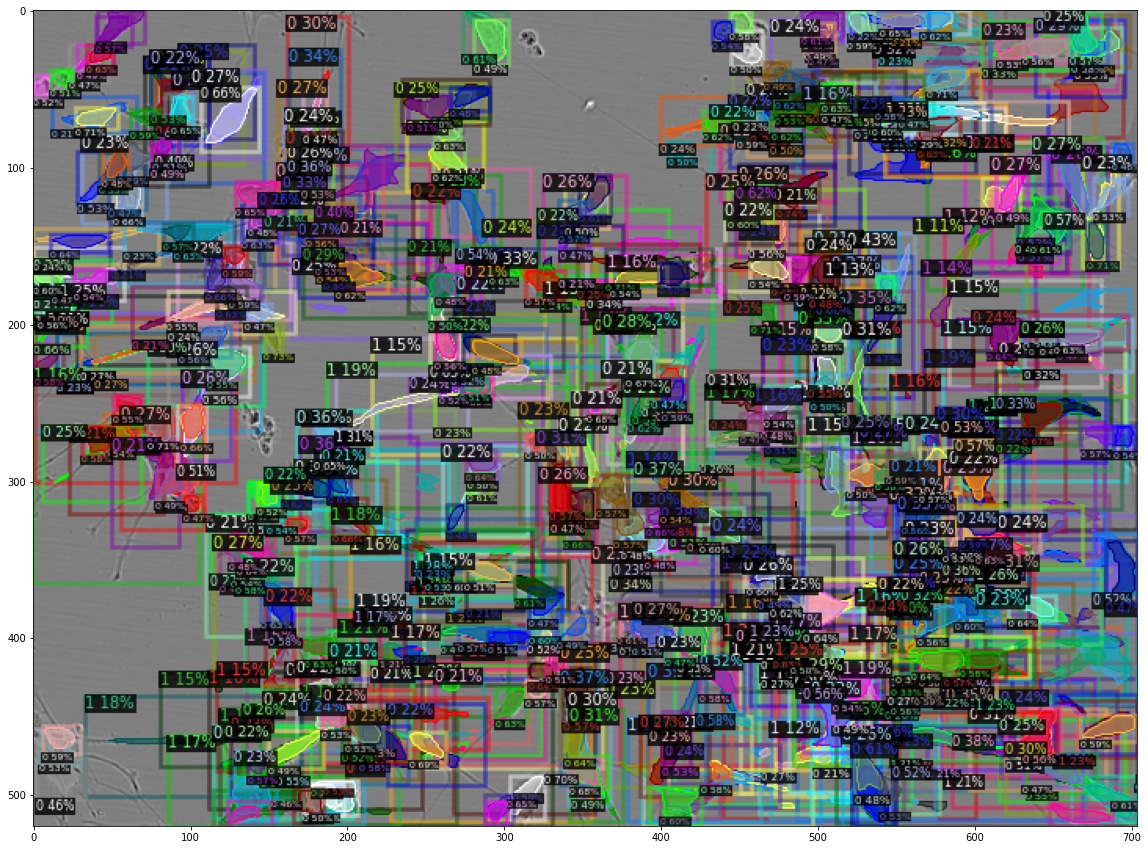

In [7]:
def plt_pred(file):
    im = cv2.imread(file)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,15))
    plt.imshow(out.get_image()[:, :, ::-1]);

if len(test_files) == 3:
    plt_pred(test_files[0])

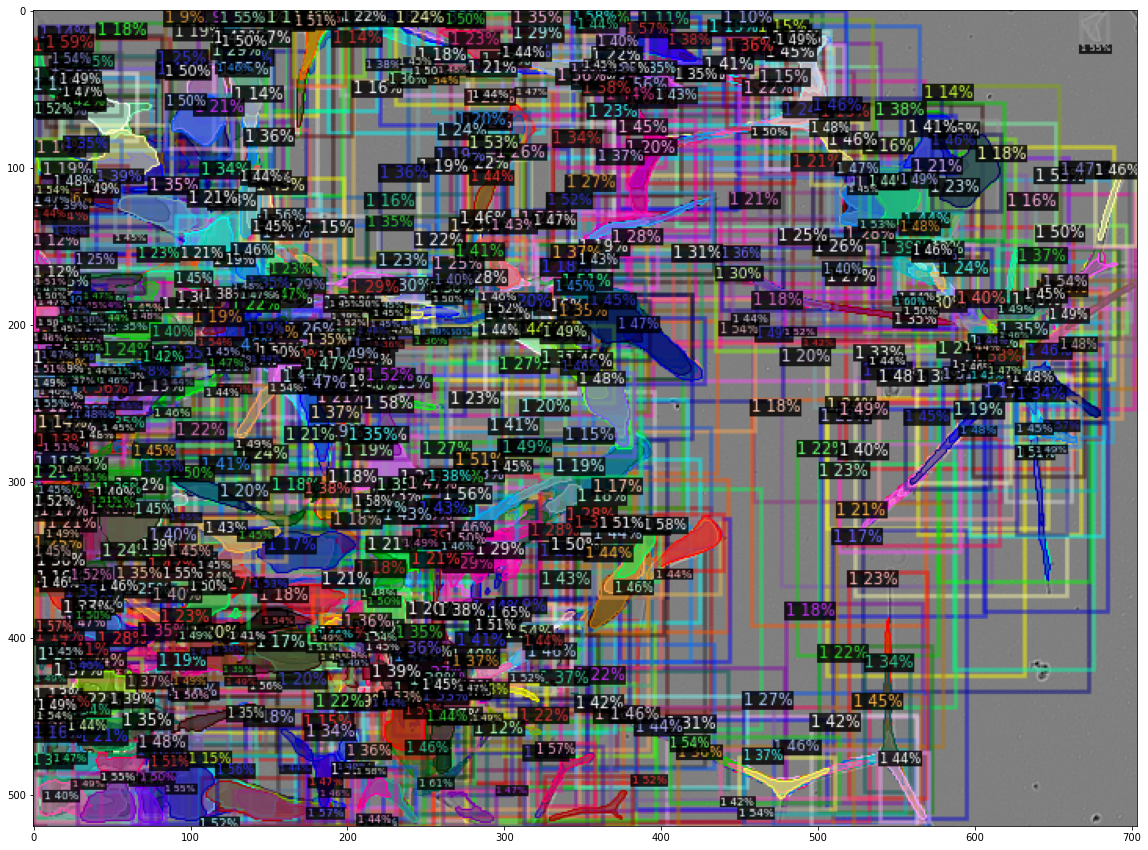

In [8]:
if len(test_files) == 3:
    plt_pred(test_files[1])

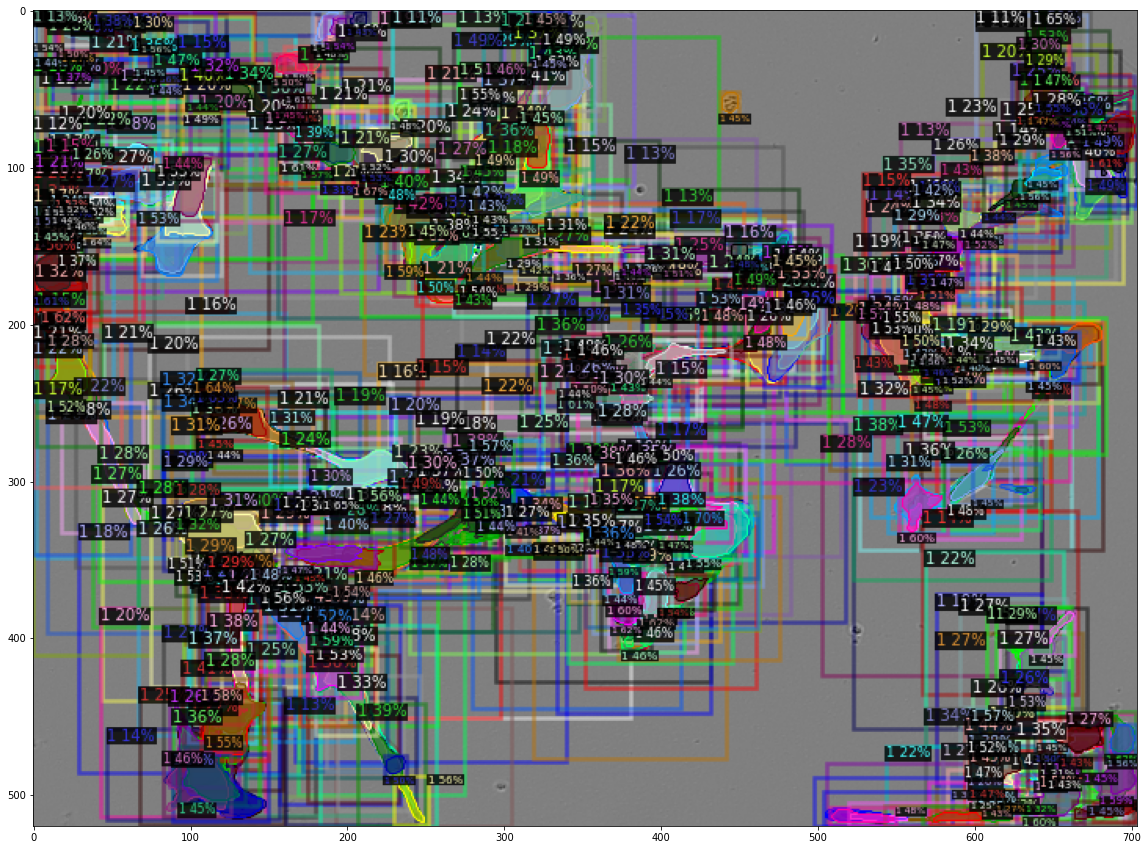

In [9]:
if len(test_files) == 3:
    plt_pred(test_files[2])

# Inference for submission
The code below is principally based on [Positive score with Detectron 3/3 - Inference](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-3-3-inference/notebook) by [Slawek Biel](https://www.kaggle.com/slawekbiel). Some major additions are made:  
  * TTA with Weighted Segments Fusion
  * Shape property measurement and filtering based on findings in [this notebook](https://www.kaggle.com/mistag/sartorius-cell-shape-analysis)
  * Check for chopping of predictions by higher score masks
  
Start by reading in properties from cell shape analysis:

In [10]:
cell_df = pd.read_pickle('/kaggle/input/sartorius-cell-shape-analysis/shape_data.pkl')
cell_df

feature  shsy5y min  shsy5y max  astro min  astro max  cort min  \
0            area      57.000     752.180     46.000   4259.920    70.000   
1  major_axis_len      10.597      63.822     12.204    205.016    11.533   
2  minor_axis_len       6.362      25.255      4.487     67.978     7.264   
3      axis_ratio       0.184       0.940      0.076      0.903     0.326   
4        solidity       0.656       0.972      0.292      0.964     0.806   
5          extent       0.282       0.829      0.104      0.775     0.456   
6            hu_0       0.162       0.534      0.164      1.719     0.160   
7            hu_1       0.000       0.244      0.000      2.864     0.000   

   cort max  
0   776.240  
1    45.296  
2    27.526  
3     0.970  
4     0.979  
5     0.847  
6     0.303  
7     0.059

## TTA function
We define three transformations plus original image.

In [11]:
# Augmentations must be "bidirectional" - applying twice will get back to original
# also augmentations must support image, bboxes and masks
AUGMENTATIONS = [None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0)]

# create dict key from bbox
def bbox_to_key(bbox):
    return str(np.round(bbox, 6))

# TTA function takes file name as input
def TTA(file, predictor):
    boxes = []
    box_scores = []
    masks = []
    masks_lkup =[]
    pclass = []
    im = cv2.imread(file)
    for aug in AUGMENTATIONS:
        if aug is not None:
            transform = aug
            ima = transform(image=im)['image']
        else:
            ima = im
        pred = predictor(ima)
        h, w = pred['instances'].image_size[0], pred['instances'].image_size[1]
        classes = pred['instances'].pred_classes.cpu().numpy()-1
        if len(pclass) == 0:
            pclass = classes
        else:
            pclass = np.concatenate((pclass, classes))
        # get box predictions
        pred_boxes = [A.normalize_bbox(box, h, w) for box in pred['instances'].pred_boxes.tensor.cpu().numpy()]
        # transform back to original
        if aug is not None:
            pred_boxes = transform(image=ima, bboxes=pred_boxes)['bboxes']
        # get mask prediction
        pred_masks = pred['instances'].pred_masks.cpu().numpy()*1
        # transform back to original
        if aug is not None:
            pred_masks = transform(image=ima, masks=pred_masks)['masks']
        # lookup table for bbox to mask index reference
        pred_dict = {}
        for i in range(len(pred_boxes)):
            pred_dict[bbox_to_key(pred_boxes[i])] = i
        # append results to list
        boxes.append(np.array(pred_boxes))
        box_scores.append(np.array(pred['instances'].scores.detach().cpu().numpy()))
        masks.append(np.array(pred_masks, dtype=np.uint8))
        masks_lkup.append(pred_dict)
    
        del pred, pred_boxes, pred_masks, ima, pred_dict
    
    del im
    gc.collect()
    predicted_class = stats.mode(pclass)[0][0]
    return boxes, box_scores, masks, masks_lkup, predicted_class

## Weighted Segments Fusion
The function below will fuse masks based on WBF boxes.

In [12]:
def get_wsf_mask(wbf_box, wbf_org, pmasks, pmasks_lkup, thres=0.5):
    w, h = 520, 704
    mask = np.zeros((w, h), dtype=np.uint8)
    for i in range(len(wbf_org)):
        key = bbox_to_key(wbf_org[i][4:])
        model = int(wbf_org[i][3])
        try:
            ind = pmasks_lkup[model][key]
            mask = mask + pmasks[model][ind]
        except:
            pass
    # convert thres to integer based on number of boxes
    threshold = max(1, int(thres*len(wbf_org)))
    # remove pixels outside WBF box
    m2 = np.zeros((w, h), dtype=np.uint8)
    x1 = max(0, int(h * wbf_box[0]))
    y1 = max(0, int(w * wbf_box[1]))
    x2 = min(h, int(h * wbf_box[2]))
    y2 = min(w, int(w * wbf_box[3]))
    m2[y1:y2, x1:x2] = 1
    mask = (mask >= threshold) * m2
    return mask.astype(np.uint8)

## Prediction function
TTA + WSF is applied below.

In [13]:
DEBUG = False

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

THRESHOLDS = [.53, .45, .55]
CLASS_LABELS = ['shsy5y', 'astro', 'cort']

# Implement WSF for TTA
def get_masks_tta(fn, predictor, thres=-1):
    im = cv2.imread(str(fn))
    h, w = im.shape[0], im.shape[1]
    # do TTA
    boxes, box_scores, masks, masks_lkup, pred_class = TTA(str(fn), predictor)
    # create dummy labels
    labels = []
    for i in range(len(boxes)):
        labels.append(np.ones(len(boxes[i]), dtype=np.uint8))
    # weighted boxes fusion
    wbf_boxes, wbf_scores, _, wbf_originals = weighted_boxes_fusion_tracking(boxes, 
                                                                             box_scores, 
                                                                             labels_list=labels, 
                                                                             iou_thr=0.55, 
                                                                             skip_box_thr=THRESHOLDS[pred_class])
    # Finally, process masks, making sure there is no overlap
    res = []
    used = np.zeros(im.shape[:2], dtype=int)
    # extract limits from DataFrame
    pred_label = CLASS_LABELS[pred_class+1]
    min_key = pred_label+' min'
    major_axis_len_min = cell_df[cell_df.feature == 'major_axis_len'][min_key].iloc[0]
    # process
    for i in range(len(wbf_boxes)):
        mask = get_wsf_mask(wbf_boxes[i], wbf_originals[i], masks, masks_lkup, thres=.5)
        # get shape properties
        try:
            props = measure.regionprops(mask)
        except:
            continue
        # if there are multiple separated masks, pick the larger one
        areas = []
        for a in range(len(props)):
            areas.append(props[a].area)
        try:
            target = np.argmax(areas)
        except:
            continue
        # extract properties of interest 
        major_axis_len = props[target].major_axis_length
        # check against limits
        if major_axis_len >= major_axis_len_min:
            mask = mask * (1-used)
            # check if mask is chopped up by previous detections
            if len(measure.find_contours(mask, 0.5, positive_orientation='low')) == 1:
                used += mask
                res.append(rle_encode(mask))
            else:
                if DEBUG:
                    print('{}: Chopped\'n\'dropped #{}'.format(fn.split('/')[-1], i))
        else:
            if DEBUG:
                print('{}: Failed limits #{}'.format(fn.split('/')[-1], i))
                
    if DEBUG:
        print('{}: {}, {} boxes of {} left after processing'.format(fn.split('/')[-1], pred_label, len(res), len(wbf_boxes)))
                
    del boxes, box_scores, masks, masks_lkup
    del wbf_boxes, wbf_scores, labels, wbf_originals
    gc.collect()
          
    return res

Go for it:

In [14]:
ids, masks=[],[]

for fn in test_files:
    fid = fn.split('/')[-1].split('.')[0]
    #print('------------------- {} --------------------'.format(fid))
    encoded_masks = get_masks_tta(fn, predictor)
    if len(encoded_masks) > 0:
        for enc in encoded_masks:
            ids.append(fid)
            masks.append(enc)
    else:
        ids.append(fid)
        masks.append('')
        
df = pd.DataFrame({'id':ids, 'predicted':masks})
df.to_csv('/kaggle/working/submission.csv', index=False)
df.head()

id                                          predicted
0  7ae19de7bc2a  75820 5 76522 8 77223 11 77925 13 78624 16 793...
1  7ae19de7bc2a  139541 5 140245 6 140948 8 141652 9 142356 9 1...
2  7ae19de7bc2a  44394 10 45092 16 45792 20 46495 21 47198 22 4...
3  7ae19de7bc2a  26625 15 27327 18 28030 19 28733 20 29436 22 3...
4  7ae19de7bc2a  177490 3 178193 4 178896 6 179600 6 180303 7 1...

In [15]:
%cd /kaggle/working
!rm -fr /kaggle/working/centermask2

/kaggle/working
